In [2]:
import io
import os
import zipfile
import numpy as np
import pandas as pd
import geopandas as gpd

# All functions created in the .py module. Import all of them in the same environment
from S2_functions import *

In [2]:
# Define user and password

user = "enter your user"
password = "enter your password"

#Function 1
connection_CopernicusHub = access_copernicusHub(user, password , "https://scihub.copernicus.eu/dhus")

In [3]:
# Convert GeoJson to WKT for input to function search_footprint_data
wkt_polygon = geojson_to_wkt(read_geojson("BoundingBox.geojson"))

#Function 2
images_search = search_footprint_data(connection_CopernicusHub, 
                                     wkt_polygon, 
                                     "20211101", 
                                     "20211130", 
                                     "Sentinel-2", 
                                     "Level-2A",
                                     (0,10), 
                                     'T28PCA',
                                     True)

title_img = images_search.get("title")
date_img = images_search.get("date").strftime("%Y%m%d")

In [4]:

print(f'Tile: {title_img.split("_")[-2]}, date: {date_img}')


Tile: T28PCA, date: 20211123


In [5]:
print(f'DOWLOADING IMAGE {title_img}')
connection_CopernicusHub.download(images_search.get("id"))

DOWLOADING IMAGE S2A_MSIL2A_20211123T113411_N0301_R080_T28PCA_20211123T143210


MD5 checksumming:   0%|          | 0.00/280M [00:00<?, ?B/s]

{'id': '270a5287-832c-4aea-9baf-bdda164f309c',
 'title': 'S2A_MSIL2A_20211123T113411_N0301_R080_T28PCA_20211123T143210',
 'size': 279929660,
 'md5': 'ed33c8b2cd80554c4c6af7b537afade2',
 'date': datetime.datetime(2021, 11, 23, 11, 34, 11, 24000),
 'footprint': 'POLYGON((-15.835815 14.15010437584977,-16.053192 14.210912587758948,-16.053894 14.20791621639734,-16.28592 14.26811430064474,-16.285553 14.269622383022853,-16.285706 14.269662460836622,-16.285645 14.269902323678751,-16.285889 14.26996359151152,-16.285767 14.270483037725857,-16.287811 14.2710022599644,-16.28769 14.271424554361689,-16.28778 14.271443815140875,-16.28778 14.271447222976583,-16.295166 14.27334238228423,-16.492767 14.32420460313718,-16.492767 14.324113252823816,-16.492828 14.324127025419672,-16.49353 14.32110493320593,-16.72055 14.375703109742464,-16.720154 14.3773609662696,-16.720245 14.377382090264138,-16.720184 14.377754590968609,-16.720306 14.377788840732782,-16.720154 14.37843518390398,-16.722107 14.37889103977224

In [6]:
zip_extract = zipfile.ZipFile(title_img+".zip")
zip_extract.extractall()


In [7]:
# VNIR bands at 10 m. 
resolution_folder = "R10m"

# Get the band numbers 

#Function 3
b_blue, b_green, b_red, b_nir = get_bands(title_img,resolution_folder)

print("--BANDS--\n")
print(b_blue,"\n\n",b_green,"\n\n",b_red,"\n\n",b_nir)


--BANDS--

S2A_MSIL2A_20211123T113411_N0301_R080_T28PCA_20211123T143210.SAFE\GRANULE\L2A_T28PCA_A033539_20211123T113448\IMG_DATA\R10m\T28PCA_20211123T113411_B02_10m.jp2 

 S2A_MSIL2A_20211123T113411_N0301_R080_T28PCA_20211123T143210.SAFE\GRANULE\L2A_T28PCA_A033539_20211123T113448\IMG_DATA\R10m\T28PCA_20211123T113411_B03_10m.jp2 

 S2A_MSIL2A_20211123T113411_N0301_R080_T28PCA_20211123T143210.SAFE\GRANULE\L2A_T28PCA_A033539_20211123T113448\IMG_DATA\R10m\T28PCA_20211123T113411_B04_10m.jp2 

 S2A_MSIL2A_20211123T113411_N0301_R080_T28PCA_20211123T143210.SAFE\GRANULE\L2A_T28PCA_A033539_20211123T113448\IMG_DATA\R10m\T28PCA_20211123T113411_B08_10m.jp2


## Stack the bands 

In [9]:
## Create a list of bands
original_bands_list = [b_blue,b_green, b_red, b_nir]
# Stack using function

#Function 4
stack_vnir_bands(original_bands_list)

raster 1 is stacked
raster 2 is stacked
raster 3 is stacked
raster 4 is stacked
Raster stack written


## Crop the image

In [10]:
stack = "stack.tif"
bBox = "BoundingBox.geojson"

# get crs of stack image
with rio.open(stack) as src :
    
    #Function 5
    crop_image(stack, gpd.read_file(bBox), True, src.crs)
    
    src.close()

## Create the binary grid

In [11]:
#Function 6
create_grid("clip_stack.tif","binary_ras.tif")


## Polygonize the raster

In [12]:
#Function 7
polygonize_grid("binary_ras.tif","grids_pol.geojson")

Create IDs in the grids

In [13]:
#Function 8
gdf_main = create_ID_gdf("grids_pol.geojson","New_ID")

## Avoid edge effects in the grids

In [14]:
#Function 9
remove_edgeEffects(gdf_main,"r_BoundingBox.geojson")

## Extract pixel values to grids

In [15]:
list_names_bands = ["blue","green", "red", "nir"]

# Function 10
extract_pixel_values("clip_stack.tif", gpd.read_file("grids_within_area.geojson"), 
                                                     "grids_values_area.geojson",
                                                     list_names_bands)

BAND -- 0
BAND -- 1
BAND -- 2
BAND -- 3
AOI with raster values generated


## Extract pixel values to training areas

In [16]:
list_names_bands = ["blue","green", "red", "nir"]

training_areas = gpd.read_file("Training_samples.geojson")

# Function 10
extract_pixel_values("clip_stack.tif", training_areas, "training_values.geojson", list_names_bands)

BAND -- 0
BAND -- 1
BAND -- 2
BAND -- 3
AOI with raster values generated


## save the processed geojson files to csv

In [23]:
#Function 11
save_to_csv("grids_values_area.geojson","gridsS2_values.csv")

#Function 11
save_to_csv("training_values.geojson","training_values.csv")


# Perform classification
## Comparing two algorithms. KNN and Decision Trees

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

n_neighbours = 5
max_depth = 50

knn_classf = KNeighborsClassifier(n_neighbors=n_neighbours, metric='minkowski') # as default, Euclidean distance

DT_classf = DecisionTreeClassifier(max_depth=max_depth, max_features='sqrt',
                                      random_state = 0)

print("Computing classification with KNN")
# Function 13 - KNN
accuracy_knn, accuracy_t_knn, conf_matrix_knn, kappa_knn, pred_dataset_knn = run_MLalgorithm("training_values.csv", 
                                                             "gridsS2_values.csv",
                                                             knn_classf, 0.3  ) 
print("Accuracy of model KNN",round(accuracy_knn,2)*100,"%" )
print("Accuracy with training KNN",round(accuracy_t_knn,2)*100,"%" )
print("KAPPA KNN:",round(kappa_knn,2) )

print("\n\nComputing classification with Decision Trees")                                                                                         
# Function 13 - Decision Trees
accuracy_dt, accuracy_t_dt, conf_matrix_dt, kappa_dt, pred_dataset_dt = run_MLalgorithm("training_values.csv", 
                                                             "gridsS2_values.csv", 
                                                                DT_classf, 0.3 )

print("Accuracy of model Decision Trees",round(accuracy_dt,2)*100,"%" )
print("Accuracy with training Decision Trees",round(accuracy_t_dt,2)*100,"%" )
print("KAPPA Decision Trees:",round(kappa_dt,2) )


Computing classification with KNN
Accuracy of model KNN 67.0 %
Accuracy with training KNN 69.0 %
KAPPA KNN: 0.2


Computing classification with Decision Trees
Accuracy of model Decision Trees 83.0 %
Accuracy with training Decision Trees 100.0 %
KAPPA Decision Trees: 0.6


## Show the confusion matrix

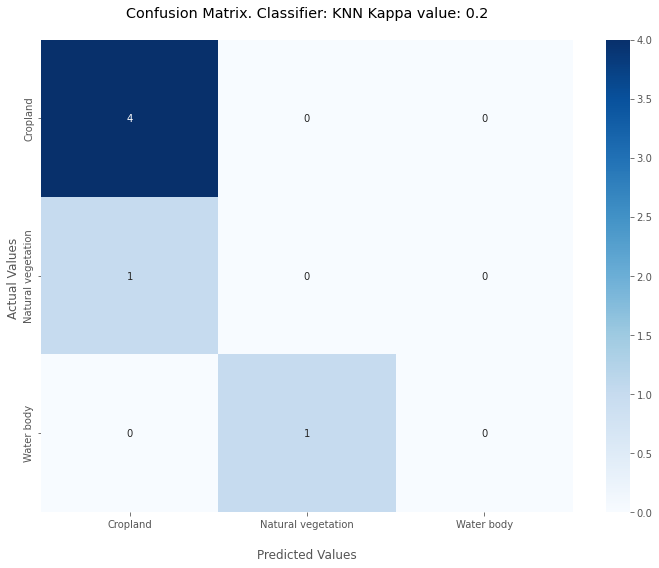

In [3]:
# Function 14 - KNN
plot_confusion_matrix(conf_matrix_knn,kappa_knn,"KNN")

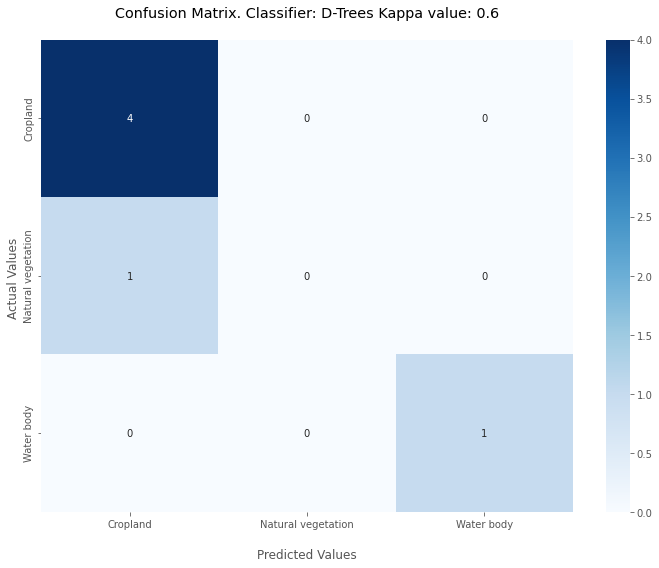

In [4]:
# Function 14 - Decision Trees
plot_confusion_matrix(conf_matrix_dt,kappa_dt,"D-Trees")

## Create classified maps 

In [5]:
# Function 15
df = gpd.read_file("grids_values_area.geojson")


LC_array_to_df(pred_dataset_dt, df,"classification_map_DT.geojson")

LC_array_to_df(pred_dataset_knn, df,"classification_map_KNN.geojson")

print("--")

--


## Plot both classifications

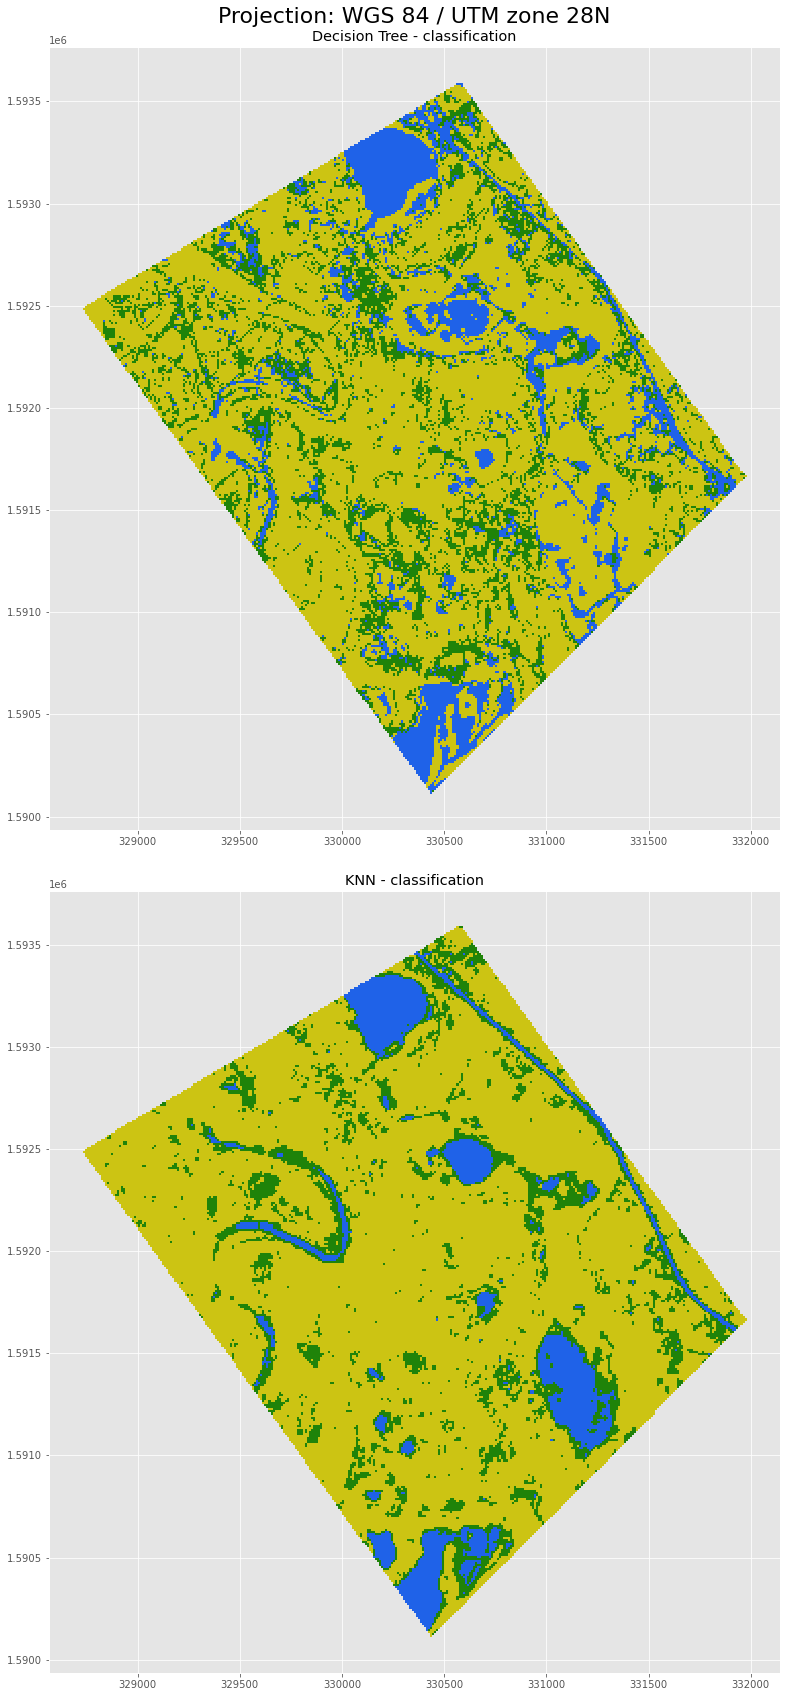

In [7]:
fig, axs = plt.subplots(2, figsize = [20,24])

color_mapping = {
   "Cropland": "#CCC413",
   "Natural vegetation": "#1F8309",
   "Water body": "#1F62E8",
   "Bare soil": "#AFA29F",
   "Built-up surface": "#EF4213"
}


dt_class = gpd.read_file("classification_map_DT.geojson")
dt_class.plot(legend=True, 
                    categorical=True, 
                    color=dt_class["LandCover"].map(color_mapping), 
                    ax = axs[0]);

knn_class = gpd.read_file("classification_map_KNN.geojson")
knn_class.plot( legend=True,
                    categorical=True, 
                    color=knn_class["LandCover"].map(color_mapping), 
                    ax = axs[1]);

axs[0].title.set_text('\nDecision Tree - classification')
axs[1].title.set_text('\nKNN - classification')

fig.suptitle('Projection: WGS 84 / UTM zone 28N', fontsize=22)

plt.savefig("Classifications.jpg",dpi = 250)

plt.tight_layout()
plt.show()
